In [1]:
## Import libraries & Packages

# Data structure and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import colorsys
import os
%matplotlib inline

from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve

# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB

# Import data (balanced_data.csv)

In [81]:
path = os.path.join('data', 'balanced_data.csv')
total_df = pd.read_csv(path, usecols=[1,2,3,4,5,7])
total_df.tail()

,url,source,title,author,text,label_num
1994,http://www.bighairynews.com/2017/07/military-t...,Bighairynews,Military Trannies Trumped,[],WASHINGTON (World News Bureau) - President Tru...,1
1995,http://bipartisanreport.com/2017/07/27/scaramu...,bipartisanreport,Scaramucci Responds To Article About His Profa...,['Holly Lee'],Anthony Scaramucci is facing serious scorn aft...,1
1996,https://amgreatness.com/2017/07/19/muellers-in...,wordpress,Mueller’s Investigation Must Be Limited and Ac...,"['Andrew C. Mccarthy', 'Sam Mcgowan', 'Bill S'...",How much goalpost moving should be tolerable i...,1
1997,http://www.politico.com/story/2017/07/26/scara...,wordpress,Scaramucci still stands to profit from SkyBrid...,"['Lorraine Woellert', 'Cristiano Lima', 'Tara ...",The incoming White House communications direct...,1
1998,http://beforeitsnews.com/health/2017/07/how-po...,beforeitsnews,How potatoes can increase the risk of cancer c...,['Natural Health'],(Before It's News)\n\n(NaturalHealth365) A rec...,1


In [83]:
# define training, cross-validation and testing sets

Y = total_df['label_num']
X = total_df.text
X_train, X_cvt, Y_train, Y_cvt = train_test_split(X, Y, test_size=0.4, random_state=42)
X_cv, X_test, Y_cv, Y_test = train_test_split(X_cvt, Y_cvt, test_size=0.6, random_state=42)

# Generate features

In [84]:
import nltk
import string
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize_stemmer(text):
    tokens = nltk.word_tokenize(text)
    # option to include punctuation or not
    #tokens = [i for i in tokens if i not in string.punctuation]
    stems = stem_tokens(tokens, stemmer)
    return stems

## Method 1: Use CountVectorizer to generate features¶

In [ ]:
# import and instantiate CountVectorizer (with the default parameters)
from sklearn.feature_extraction.text import CountVectorizer

# instantiate the vectorizer
vect = CountVectorizer()

In [ ]:
# learn training data vocabulary, then use it to create a document-term matrix
vect.fit(X_train)

In [ ]:
X_train_tot = vect.transform(X_train)
X_test_tot = vect.transform(X_test)
X_cv_tot = vect.transform(X_cv)

## Method 2: Use TF-IDF to generate features¶

In [85]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(tokenizer=tokenize_stemmer,stop_words='english',ngram_range=(2, 2))

In [86]:
tfidf.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(2, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function tokenize_stemmer at 0x11fe19c80>, use_idf=True,
        vocabulary=None)

In [87]:
X_train_tot = tfidf.transform(X_train)
X_test_tot = tfidf.transform(X_test)
X_cv_tot = tfidf.transform(X_cv)

## Feature selection

In [73]:
from sklearn.feature_selection import SelectPercentile, SelectKBest, f_classif, chi2

In [88]:
# select top 8% features
selector = SelectPercentile(chi2, percentile = 5) 

# select top 25000 features
#selector = SelectKBest(chi2, k = 20000) 

selector.fit(X_train_tot, Y_train)
X_train_selected = selector.transform(X_train_tot)
X_test_selected = selector.transform(X_test_tot)
X_cv_selected = selector.transform(X_cv_tot)

print("X_train_selected shape: ", X_train_selected.shape)
print("X_test_selected shape: ", X_test_selected.shape)
print("X_cv_selected shape: ", X_cv_selected.shape)

X_train_selected shape:  (1199, 16472)
X_test_selected shape:  (480, 16472)
X_cv_selected shape:  (320, 16472)


In [89]:
X_train_dtm = X_train_selected
X_test_dtm = X_test_selected
X_cv_dtm = X_cv_selected

# Test different models

In [90]:
# validation test & Learning curve

def valid_test(model, param, param_candidates):
    
#     candidates = np.logspace(-7, 7, 10) # for alpha, C 
#     candidates = [1,2,3,4,5,6,7,8,9,10]# for integers
    train_scores, valid_scores = validation_curve(model, X_cv_dtm, Y_cv, param, param_candidates)
    avg_ts, avg_vs = train_scores.mean(axis = 1), valid_scores.mean(axis = 1)
    sd_ts, sd_vs = train_scores.std(axis = 1), valid_scores.std(axis = 1)
    vs_max_ix = np.argmax(avg_vs)
    best = param_candidates[vs_max_ix]
    print('The best {} value for {} is {}'.format(param, model, best))
    plt.figure(figsize=(10, 6))
    plt.title('Validation Test')
    plt.ylabel('Scores')
    plt.xlabel('Candidate {} index'.format(param))
    plt.plot(range(10), avg_ts, label = 'Training Scores')
    plt.plot(range(10), avg_vs, label = 'Cross validation Scores')
    plt.legend(loc = 'best')
    return best

def Learning_curve(model):
    train_sizes = [50,100,150,200,250,300,350,400]
    train_sizes, train_scores, test_scores = learning_curve(model, X_train_dtm, Y_train, train_sizes=train_sizes)   
    train_scores_mean, test_scores_mean = train_scores.mean(axis = 1), test_scores.mean(axis = 1)
    train_scores_std, test_scores_std = train_scores.std(axis = 1), test_scores.std(axis = 1)
    plt.figure(figsize=(10, 6))
    plt.title('Learning curve')
    plt.ylabel('Scores')
    plt.xlabel('Training Set')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc = 'best')
    plt.show()
    
def plot_roc_curve(model):
    y_pred_prob = model.predict_proba(X_test_dtm)
    fpr, tpr, thrs = roc_curve(Y_test, y_pred_prob[:,1])
        
    plt.figure(figsize=(10, 6))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='Logistic Regression', color='darkorange',lw = 3)
    plt.xlabel('False Positive Rate',fontsize=13.5)
    plt.ylabel('True Positive Rate',fontsize=13.5)
    plt.title('ROC Curve',fontsize=13.5)
    plt.show()
    print('AUC is {}'.format(auc(fpr, tpr)))

def plot_precision_recall(model):
    y_pred_dec = model.decision_function(X_test_dtm)
    precision, recall, thresholds = precision_recall_curve(Y_test, y_pred_dec)
    plt.figure(figsize=(10, 6))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(recall, precision, label='Logistic Regression', color='teal',lw = 3)
    plt.xlabel('Recall',fontsize=13.5)
    plt.ylabel('Precision',fontsize=13.5)
    plt.title('Recall-Precision curve',fontsize=13.5)
    plt.show()

def print_scores(model, y_test_pred):
    print('Train score is {}'.format(model.score(X_train_dtm, Y_train)))
    print('Test score is {}'.format(model.score(X_test_dtm, Y_test)))
    print('F1 score is {}'.format(f1_score(Y_test,y_test_pred)))
        

## 1. Logistic Regression

The best C value for LogisticRegression(C=10000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False) is 1000000.0


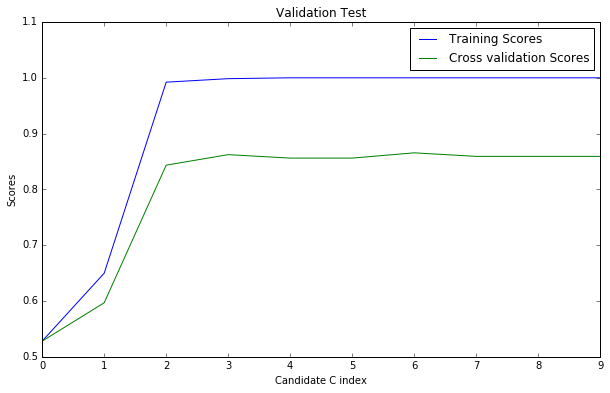

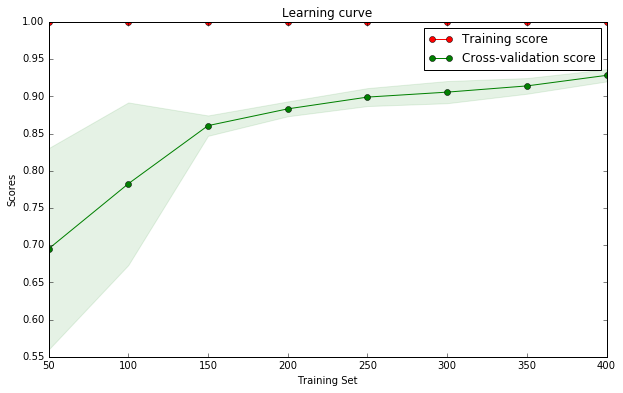

In [91]:
best_C = valid_test(LogisticRegression(), "C", np.logspace(-2, 10, 10))
LR = LogisticRegression(C = best_C)
#LR = LogisticRegression()
Learning_curve(LR)
LR.fit(X_train_dtm, Y_train)
Y_test_pred_LR = LR.predict(X_test_dtm)

# polynomial_features = PolynomialFeatures(degree=2,include_bias=False)
# pipeline = Pipeline([("polynomial_features", polynomial_features), ("linear_regression", LR)])
# Learning_curve(pipeline)
# # Learning_curve(LR)

# pipeline.fit(X_train, Y_train)
# Y_test_pred_LR = pipeline.predict(X_test)
# print('Train score is {}'.format(pipeline.score(X_train, Y_train)))
# print('Cross validation score is {}'.format(pipeline.score(X_cv, Y_cv)))

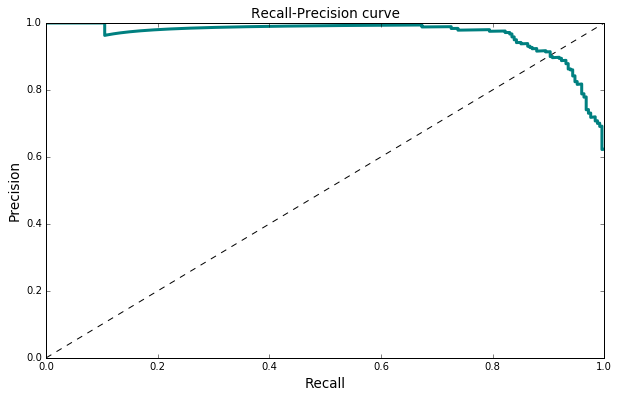

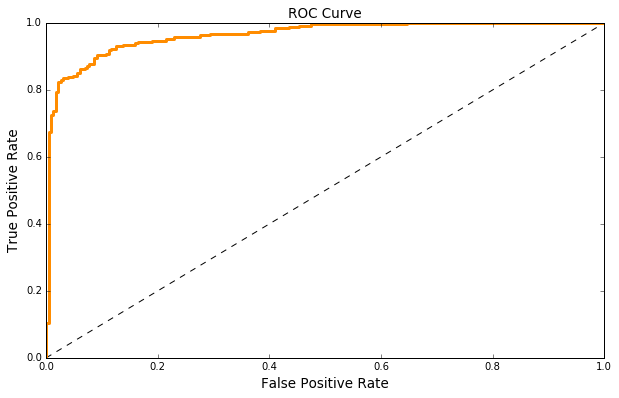

AUC is 0.9648741657397107
Train score is 0.9991659716430359
Test score is 0.89375
F1 score is 0.8921775898520085


In [92]:
# plot precision recall curve
plot_precision_recall(LR)
# plot ROC curve
plot_roc_curve(LR)
# print scores
print_scores(LR, Y_test_pred_LR)

## 2. Neural networking (MLP)

In [ ]:
best_alpha = valid_test(MLPClassifier(), 'alpha', np.logspace(-5, -1, 10))
MLP = MLPClassifier(alpha=best_alpha, hidden_layer_sizes=(10, 10, 10), random_state=1, max_iter=200)
# MLP = MLPClassifier(alpha=1e-05, hidden_layer_sizes=(12, 12, 12), random_state=1, max_iter=200)
MLP.fit(X_train_dtm, Y_train)
Learning_curve(MLP)
Y_test_pred_MLP = MLP.predict(X_test_dtm)

# polynomial_features = PolynomialFeatures(degree=2,include_bias=False)
# pipeline = Pipeline([("polynomial_features", polynomial_features), ("MLP_Classifier", MLP)])
# pipeline.fit(X_train, Y_train)
# Learning_curve(pipeline)
# Y_test_pred_MLP = MLP.predict(X_test)

# print('train score is {}'.format(pipeline.score(X_train, Y_train)))
# print('cross validation score is {}'.format(pipeline.score(X_cv, Y_cv)))

In [ ]:
# plot precision recall curve
plot_precision_recall(MLP, X_test_dtm, Y_test)
# plot ROC curve
plot_roc_curve(MLP, X_test_dtm, Y_test)
# print scores
print_scores(MLP, X_train_dtm, Y_train, X_test_dtm, Y_test, Y_test_pred_MLP)

## 3. Support Vector Machines

In [ ]:
best_gamma = valid_test(SVC(), "gamma", np.logspace(-5, 5, 10))
best_C = valid_test(SVC(gamma = best_gamma), "C", np.logspace(-5, 5, 10))
svm = SVC(C = best_C, gamma = best_gamma)
# svm = SVC(C = 3.6, gamma = 0.0016)
svm.fit(X_train_dtm, Y_train)
Learning_curve(svm)
Y_test_pred_svm = svm.predict(X_test_dtm)

In [ ]:
# plot precision recall curve
plot_precision_recall(svm, X_test_dtm, Y_test)
# plot ROC curve
#plot_roc_curve(svm, X_test_dtm, Y_test)
# print scores
print_scores(svm, X_train_dtm, Y_train, X_test_dtm, Y_test, Y_test_pred_svm)

## 4. RandomForestClassifier

The best n_estimators value for RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=11, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False) is 10


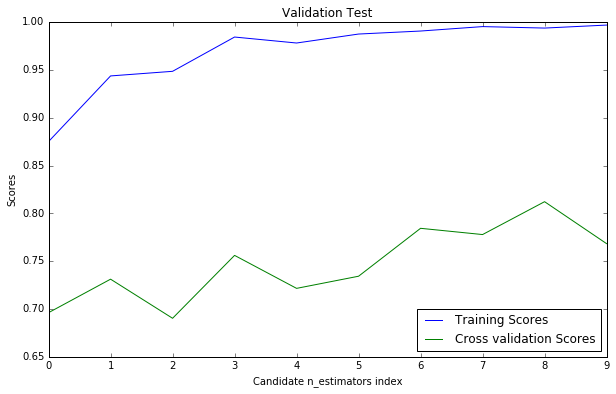

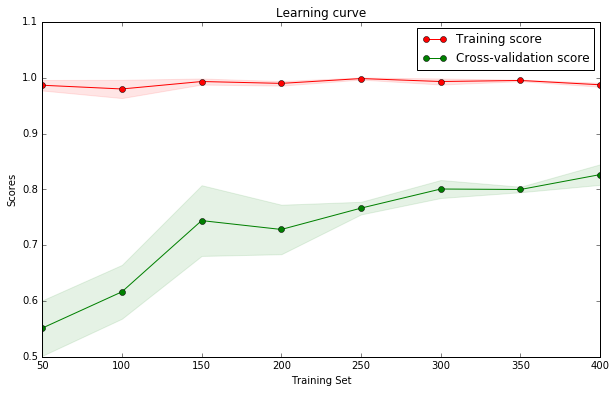

CPU times: user 70.3 ms, sys: 369 µs, total: 70.7 ms
Wall time: 70.7 ms


In [93]:
best_estimator = valid_test(RandomForestClassifier(), "n_estimators", [x for x in range(2,12)])
RF = RandomForestClassifier(n_estimators=best_estimator)
Learning_curve(RF)
%time RF.fit(X_train_dtm, Y_train)
Y_test_pred_RF = RF.predict(X_test_dtm)

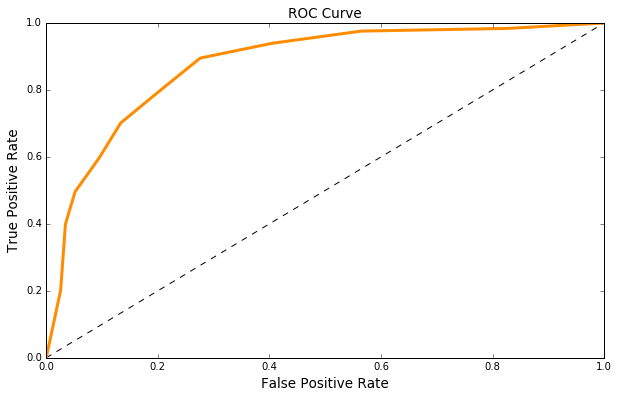

AUC is 0.8752693965517241
Train score is 0.9924937447873228
Test score is 0.78125
F1 score is 0.7682119205298015


In [95]:
# RF does not have decision_function
#plot_precision_recall(RF, X_test_dtm, Y_test)

# plot ROC curve
plot_roc_curve(RF)
# print scores
print_scores(RF, Y_test_pred_RF)

## 5. naive_bayes

The best alpha value for MultinomialNB(alpha=100.0, class_prior=None, fit_prior=True) is 0.01


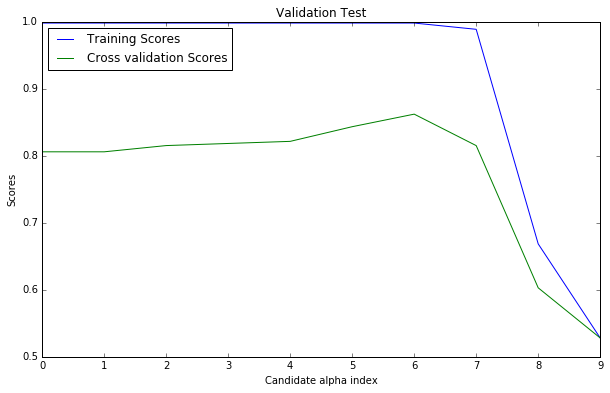

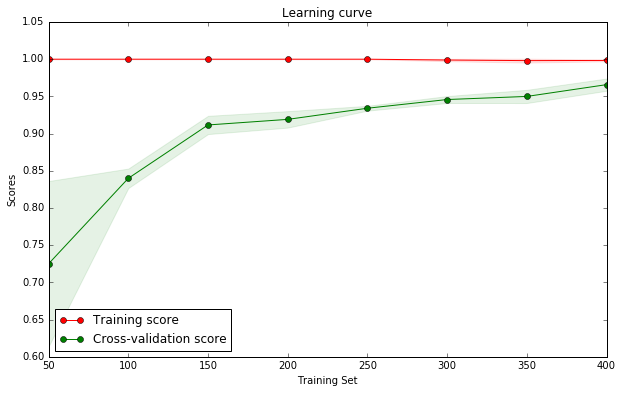

CPU times: user 2.36 ms, sys: 258 µs, total: 2.62 ms
Wall time: 2.4 ms


In [96]:
best_alpha = valid_test(MultinomialNB(), "alpha", np.logspace(-10, 2, 10))
nb = MultinomialNB(alpha = best_alpha)
#nb = MultinomialNB()
Learning_curve(nb)
%time nb.fit(X_train_dtm, Y_train)
Y_test_pred_nb = nb.predict(X_test_dtm)    

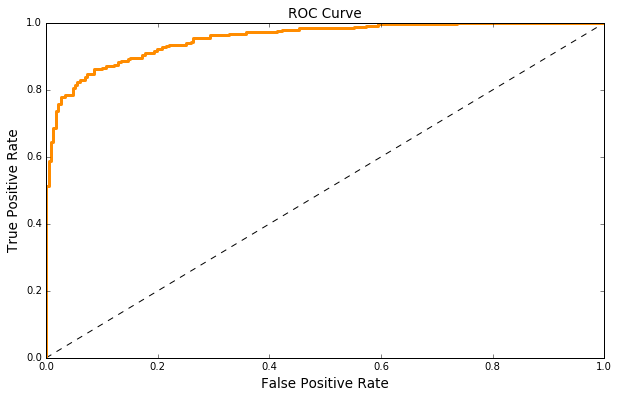

AUC is 0.9543242491657398
Train score is 0.9966638865721434
Test score is 0.8729166666666667
F1 score is 0.8647450110864746


In [97]:
# nb does not have decision_function
#plot_precision_recall(nb)

# plot ROC curve
plot_roc_curve(nb)
# print scores
print_scores(nb, Y_test_pred_nb)